In [425]:
import numpy as np
import pandas as pd
from scipy import signal, ndimage, interpolate, stats
import sys, os, time, json
from pathlib import Path
import pickle as pkl

sys.path.append('../PreProcessing/')
sys.path.append('../Lib/')
sys.path.append('../Analyses/')

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.text import Text

import TreeMazeFunctions as TMF
import spike_functions as SF
import spatial_tuning as ST
import plot_functions as PF
import TrialAnalyses as TA
from importlib import reload  # Python 3.4+ only.


In [2]:
oakPaths = {}
oakPaths['Root'] = Path('/mnt/o/giocomo/alexg/')
oakPaths['Clustered'] = Path('/mnt/o/giocomo/alexg/Clustered/')
oakPaths['PreProcessed'] = Path('/mnt/o/giocomo/alexg/PreProcessed/')
oakPaths['Raw'] = Path('/mnt/o/giocomo/alexg/RawData/InVivo/')
oakPaths['Analyses'] = Path('/mnt/o/giocomo/alexg/Analyses')

In [3]:
animals = ['Li','Cl']

an = 'Li'

In [4]:
fn = oakPaths['Root'] / (an+'_AnalysesTable.csv')
aTable = pd.read_csv(fn,index_col=0)

fn = oakPaths['Root'] / (an+'_SessionPaths.pkl')

with fn.open(mode="rb") as f:
    sePaths = pkl.load(f)


In [426]:
mods = {}
params = TA.getParamSet()
for k,pp in params.items():
    s =''
    for p in pp:
        s+='-'+p
    mods[k]=s[1:]

In [427]:
def loadSessionData(sessionPaths):
    wfi = {}
    bin_spikes = {}
    fr = {}
    for ut in ['Cell','Mua']:
        with sessionPaths[ut+'_WaveFormInfo'].open(mode='rb') as f:
            wfi[ut] = pkl.load(f)
        bin_spikes[ut]=np.load(sessionPaths[ut+'_Bin_Spikes'])
        fr[ut] = np.load(sessionPaths[ut+'_FR'])
    
    with sessionPaths['Spike_IDs'].open() as f:
        ids = json.load(f)
    with sessionPaths['ZoneAnalyses'].open(mode='rb') as f:
        za = pkl.load(f)
    
    PosDat = TMF.getBehTrackData(sessionPaths)
    
    TrialLongMat = pd.read_csv( sessionPaths['TrLongPosMat'],index_col=0)
    TrialFRLongMat = pd.read_csv(sessionPaths['TrLongPosFRDat'],index_col=0)
    fitTable = pd.read_csv(sessionPaths['TrModelFits'],index_col=0)
    
    if isinstance(fitTable,pd.core.frame.DataFrame):
        nUnits = fitTable.shape[0]
        x=[]
        for i in np.arange(nUnits):
            if np.isnan(fitTable['modelNum'][i]):
                x.append('UnCla')
            else:
                x.append(mods[fitTable['modelNum'][i]])
        fitTable['selMod'] = x
    
    dat = {}
    dat['wfi'] = wfi
    dat['bin_spikes'] = bin_spikes
    dat['fr'] = fr
    
    dat['ids'] = ids
    dat['za'] = za
    
    dat['PosDat'] = PosDat
    dat['TrialLongMat'] = TrialLongMat
    dat['TrialFRLongMat'] = TrialFRLongMat
    dat['TrialModelFits'] = fitTable
    
    
    return dat




In [428]:
se = 'Li_T3g_060418'
dat = loadSessionData(sePaths[se])

Loading Beh Tracking Data
Complete.


,ut,FullMod_tR2,modelNum,trainR2,AICc,testR2,Loc:IO,Loc,IO,Cue,Desc,Co,selMod
0,cell,0.112063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
1,cell,0.558580,31.0,0.630962,3298.949146,0.554684,23.461443,24.838586,1.820952,NaN,NaN,NaN,Loc:IO-Loc-IO
2,cell,0.609830,33.0,0.718256,3705.684042,0.615870,30.848068,40.206015,19.062448,NaN,5.073159,NaN,Loc:IO-Loc-IO-Desc
3,cell,0.625478,36.0,0.676778,3329.929336,0.624109,27.689482,43.623683,21.175654,5.550799,NaN,6.1731,Loc:IO-Loc-IO-Cue-Co
4,cell,0.591286,33.0,0.652010,3253.379867,0.593817,28.808417,32.457323,25.750658,NaN,6.479167,NaN,Loc:IO-Loc-IO-Desc
5,mua,0.031192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
6,mua,0.078649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
7,mua,0.022683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
8,mua,0.000071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
9,mua,0.120726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla


In [224]:
def plotSpikeWFs(wfi,plotStd=0,ax=None):
    wfm = wfi['mean']
    wfstd = wfi['std']
    
    if (ax is None):
        f,ax = plt.subplots(1,figsize=(6,4))
        
    sns.set(style="whitegrid",font_scale=1.2,rc={
        'axes.spines.bottom': False,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.edgecolor':'0.5'})
    
    nSamps,nChan = wfm.shape
    x = np.arange(nSamps)
    ax.plot(x,wfm,lw=3,alpha=0.9)
    ax.get_yaxis().set_ticklabels([])
    if plotStd:
        for ch in np.arange(nChan):
            plt.fill_between(x,wfm[:,ch]-wfstd[:,ch],wfm[:,ch]+wfstd[:,ch],alpha=0.1)
            
    plt.legend(['ch'+str(ch) for ch in np.arange(nChan)],loc='best',frameon=False)
    if nSamps==64:
        ax.get_xaxis().set_ticks([0,16,32,48,64])
        ax.get_xaxis().set_ticklabels(['0','','1','','2'])
        ax.set_xlabel('Time [ms]')
    ax.text(0.65,0.1,'mFR={0:.2f}[sp/s]'.format(wfi['mFR']),transform=ax.transAxes)
    ax.set_title('WaveForms')
    return ax

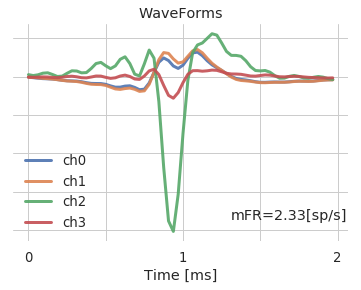

In [225]:
plotSpikeWFs(dat['wfi']['Cell'][0])

In [222]:
def plotRateMap(binSpikes, PosDat, OccInfo, cbar = False, ax=None):
    spikesByPos = ST.getPosBinSpikeMaps(binSpikes,PosDat)
    FR_ByPos = ST.getPosBinFRMaps(spikesByPos,OccInfo['time'])
    
    if (ax is None):
        f,ax = plt.subplots(1,figsize=(4,4))
    cmap = 'viridis'
    colbar_label = 'FR [sp/s]'
    smooth =  True
    robust = False
    w =4
    s=1
    ax.axis('equal')
    pos = ax.get_position()
    if cbar:
        cax = plt.axes([pos.x0+pos.width,pos.y0,0.05*pos.width,0.3*pos.height])
    if smooth:
        FR_ByPos = ST.getSmoothMap(FR_ByPos,w,s)
    maxFR = np.max(FR_ByPos)    
    with sns.plotting_context(font_scale=1):
        if cbar:
            ax=sns.heatmap(FR_ByPos.T,xticklabels=[],yticklabels=[],ax=ax,square=False, robust=robust, cbar_ax=cax, cmap=cmap,cbar_kws={'label': colbar_label})
        else:
            #ax=sns.heatmap(FR_ByPos.T,xticklabels=[],yticklabels=[],ax=ax,square=False, robust=robust, cbar=False, cmap=cmap)
            #ax=sns.heatmap(FR_ByPos.T,xticklabels=[],yticklabels=[],ax=ax,square=False, robust=robust, cbar=False, cmap=cmap)
            ax=sns.heatmap(FR_ByPos.T,xticklabels=[],yticklabels=[],ax=ax,square=True, robust=robust, cbar=False, cmap=cmap, vmin=0, vmax=maxFR*0.9)
            ax.text(0.7,0.12,'{0:.2f}[Hz]'.format(maxFR),color='w',transform=ax.transAxes)
            
        ax.invert_yaxis()
    ax.set_title('Rate Map')
    return ax

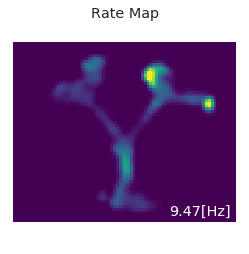

In [223]:
ax=plotRateMap(dat['bin_spikes']['Cell'][0],dat['PosDat'], dat['za']['OccInfo'])

In [220]:
def plotISIh(wfi,ax=None):
    x = wfi['isi_h'][1][1:]
    h = wfi['isi_h'][0]
    #h = h/np.sum(h)

    if (ax is None):
        f,ax = plt.subplots(1,figsize=(4,3))
    
    sns.set(style="whitegrid",font_scale=1.2,rc={
        'axes.spines.bottom': False,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.edgecolor':'0.5'})
    
    ax.bar(x,h,color=[0.3,0.3,0.4],alpha=0.8)
    ax.set_xlabel('ISI [ms]')
    ax.text(0.7,0.7,'CV={0:.2f}'.format(wfi['cv']),transform=ax.transAxes)
    ax.set_yticklabels([''])
    ax.set_title('ISI Hist')
    return ax
    

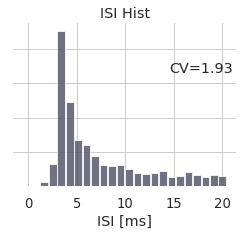

In [221]:
#plt.bar(dat['wfi']['Cell'][0]['isi_h'][1][1:],dat['wfi']['Cell'][0]['isi_h'][0])
plotISIh(dat['wfi']['Cell'][0])

In [218]:
def plotTracesSpikes(PosDat,spikes,ax=None):
    if (ax is None):
        f,ax = plt.subplots(1,figsize=(4,4))
        
    x = PosDat['x']
    y = PosDat['y']
    ax.scatter(x,y,0.2,marker='D',color=np.array([0.3,0.3,0.3])*2,alpha=0.05)
    if len(spikes)==len(x):
        ax.scatter(x,y,s=spikes, alpha=0.1, color = 'r')
    ax.set_axis_off()
    ax.set_xlim(TMF.x_limit)
    ax.set_ylim(TMF.y_limit)
    ax.set_title('Spike Traces')
    return ax

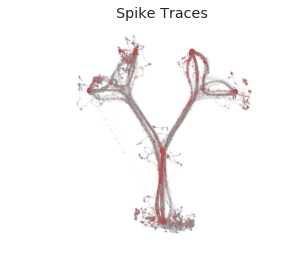

In [219]:
plotTracesSpikes(dat['PosDat'],dat['bin_spikes']['Cell'][0])
#f,ax = plt.subplots(1,figsize=(5,5))
# PF=reload(PF)
# ax=PF.plotTM_Trace(ax,dat['PosDat']['x'],dat['PosDat']['y'],bin_spikes=dat['bin_spikes']['Cell'][0], plot_raw_traces=1,plot_zones=0)

In [229]:
dat['za']['FR_Zone']['Cells'][0]

,Home,SegA,Center,SegB,I1,SegC,G1,SegD,G2,SegE,I2,SegF,G3,SegG,G4
All,0.954339,2.634274,3.165379,2.350739,2.885412,2.953722,3.794650,4.720896,4.203670,1.917758,1.543792,2.723591,3.047227,1.723778,1.890825
H1,0.844630,2.800187,3.251741,2.235300,2.853522,2.359875,3.048328,5.382514,4.573533,1.819051,1.746788,3.367845,3.774672,1.839381,2.046330
H2,1.045399,2.471026,3.048925,2.489643,2.922478,3.660021,4.590116,3.705886,3.731792,2.004020,1.398002,2.406162,2.544971,1.538487,1.668860
CL,0.953604,3.805920,4.079974,2.422791,4.097115,3.983007,3.543261,4.641293,3.788541,1.397518,1.349614,1.970063,1.875907,1.576351,1.449598
CR,1.012168,2.391468,2.118196,1.774582,2.550216,2.955989,8.545538,3.606097,2.744714,1.443077,0.767800,1.466168,2.240741,1.439683,0.683030
CO,0.852801,1.984217,2.244406,2.829922,3.030966,2.765189,2.899710,6.893349,5.467618,2.511678,2.178634,3.538660,3.357070,1.924207,2.131674
In,NaN,1.967000,NaN,2.968779,NaN,2.642451,NaN,6.652852,NaN,2.477683,NaN,3.619238,NaN,2.281630,NaN
Out,NaN,3.268342,NaN,1.866242,NaN,3.206356,NaN,2.500203,NaN,1.427336,NaN,2.039677,NaN,0.890476,NaN


In [312]:
def plotZoneAvgMaps(ZoneAct,vmax = None,ax=None):
    if (ax is None):
        f,ax = plt.subplots(1,figsize=(6,6))
        
    ax.axis('equal')
    pos = ax.get_position()
    cax = plt.axes([pos.x0+pos.width*0.78,pos.y0+0.05,0.05*pos.width,0.25*pos.height])
    
    #cDat,colArray =  PF.getDatColorMap(ZoneAct)
    #cMap = plt.get_cmap('RdBu_r')
    cMap=mpl.colors.ListedColormap(sns.diverging_palette(250, 10, s=90, l=50,  n=50, center="dark"))
    if vmax is None:
        minima = np.min(ZoneAct)
        maxima = np.max(ZoneAct)
        vmax = np.max(np.abs([minima,maxima]))
    norm = mpl.colors.Normalize(vmin=-vmax, vmax=vmax, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cMap)
    
    cnt=0
    for zo in TMF.ZonesNames:
        #PF.plotPoly(TMF.MazeZonesGeom[zo],ax,color=cDat[cnt],alpha=1)
        PF.plotPoly(TMF.MazeZonesGeom[zo],ax,color=mapper.to_rgba(ZoneAct[cnt]),alpha=1)
        
        cnt+=1
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        
    ax.set_axis_off()
    ax.set_xlim(TMF.x_limit)
    ax.set_ylim(TMF.y_limit)
    ax.axis('equal')

#     cNorm = mpl.colors.Normalize(vmin=colArray[0],vmax=colArray[-1])
#     sm = plt.cm.ScalarMappable(cmap=cMap,norm=cNorm)
    mapper.set_array([])

    cbar = plt.colorbar(mapper,cax=cax)
    cax.yaxis.set_tick_params(right=False)
    
    return ax,cax

In [273]:
plt.get_cmap('RdBu_r')

Text(0.5, 1.0, 'FR by Zone')

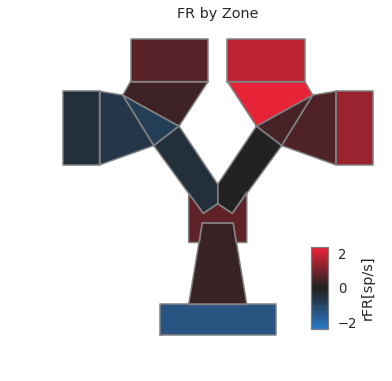

In [313]:
PF = reload(PF)
ax,cax=plotZoneAvgMaps(dat['za']['FR_Zone']['Cells'][0].loc['All']-dat['wfi']['Cell'][0]['mFR'])
cax.set_ylabel('rFR[sp/s]')
ax.set_title('FR by Zone')

Text(0.5, 1.0, 'FR Stability')

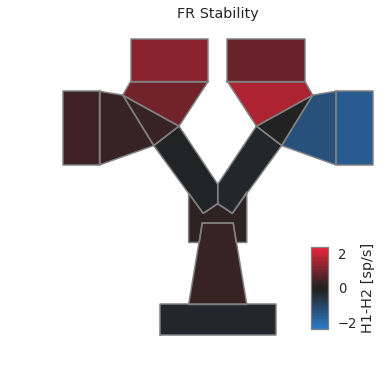

In [316]:
x = dat['za']['FR_Zone']['Cells'][0].loc['H1']
y = dat['za']['FR_Zone']['Cells'][0].loc['H2']
ax,cax=plotZoneAvgMaps(x-y,vmax=dat['wfi']['Cell'][0]['mFR'])
cax.set_ylabel('H1-H2 [sp/s]')
ax.set_title('FR Stability')

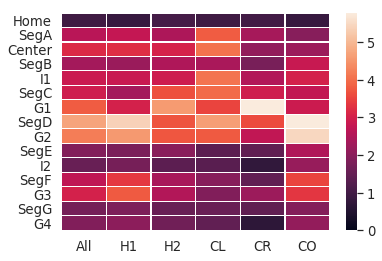

In [331]:
sns.heatmap(dat['za']['FR_Zone']['Cells'][0].loc[['All','H1','H2','CL','CR','CO']].T,vmin=0,robust=True,linewidths=0.3)

In [358]:
def plotTrial_IO(frVector,trDat,ax=None):
    if (ax is None):
        f,ax = plt.subplots(1,figsize=(4,4))
        
    cellDat = trDat.copy()
    cellDat.loc[:,'zFR'] = frVector
    subset = cellDat['Co']=='Co'
    
    dat =[]
    dat = cellDat[subset].groupby(['trID','IO','Cue','Desc']).mean()
    dat = dat.reset_index()
    
    pal = sns.xkcd_palette(['spring green','light purple'])
    with sns.color_palette(pal):
        ax=sns.violinplot(y='zFR',x='IO',hue='Desc',data=dat,split=True, ax=ax,
                          scale='count',inner='quartile',hue_order=['L','R'],saturation=0.5,order=['Out','In','O_I'])
    pal = sns.xkcd_palette(['emerald green','medium purple'])
    with sns.color_palette(pal):
        ax=sns.stripplot(y='zFR',x='IO',hue='Desc',data=dat,dodge=True,hue_order=['L','R'],alpha=0.7,ax=ax,
                         edgecolor='gray',order=['Out','In','O_I'])
        
    l=ax.get_legend()
    l.set_visible(False)
    ax.set_xlabel('Direction')
    
    return ax

In [362]:
def plotTrial_Desc(frVector,trDat,ax=None):
    if (ax is None):
        f,ax = plt.subplots(1,figsize=(4,4))
        
    cellDat = trDat.copy()
    cellDat.loc[:,'zFR'] = frVector    
    subset= cellDat['IO']=='Out'
    
    dat = []
    dat = cellDat[subset].groupby(['trID','Cue','Co','Desc']).mean()
    dat = dat.reset_index()

    pal = sns.xkcd_palette(['spring green','light purple'])
    with sns.color_palette(pal):
        ax=sns.violinplot(y='zFR',x='Desc',hue='Cue',data=dat,split=True,scale='width',ax=ax,
                          inner='quartile',order=['L','R'],hue_order=['L','R'],saturation=0.5)
    pal = sns.xkcd_palette(['emerald green','medium purple'])
    with sns.color_palette(pal):
        ax=sns.stripplot(y='zFR',x='Desc',hue='Cue',data=dat,dodge=True,order=['L','R'],ax=ax,
                            hue_order=['L','R'],alpha=0.7,edgecolor='gray')

    #
    ax.set_xlabel('Decision')
    #ax.set_ylabel('')
    
    l=ax.get_legend()
    handles, labels = ax.get_legend_handles_labels()
    l.set_visible(False)
    plt.legend(handles[2:],labels[2:],bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.,frameon=False,title='Cue')

    return ax

In [356]:
ut = 'Cell'
unitNum = 0
unitInfo = dat['wfi'][ut][unitNum][]

trMat = dat['TrialLongMat']
frVec = 

SyntaxError: invalid syntax (<ipython-input-356-16d0ff424391>, line 3)

In [436]:
print(dat.keys())
dat['TrialModelFits']#[['testR2','selMod']]

dict_keys(['wfi', 'bin_spikes', 'fr', 'ids', 'za', 'PosDat', 'TrialLongMat', 'TrialFRLongMat', 'TrialModelFits'])


,ut,FullMod_tR2,modelNum,trainR2,AICc,testR2,Loc:IO,Loc,IO,Cue,Desc,Co,selMod
0,cell,0.112063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
1,cell,0.558580,31.0,0.630962,3298.949146,0.554684,23.461443,24.838586,1.820952,NaN,NaN,NaN,Loc:IO-Loc-IO
2,cell,0.609830,33.0,0.718256,3705.684042,0.615870,30.848068,40.206015,19.062448,NaN,5.073159,NaN,Loc:IO-Loc-IO-Desc
3,cell,0.625478,36.0,0.676778,3329.929336,0.624109,27.689482,43.623683,21.175654,5.550799,NaN,6.1731,Loc:IO-Loc-IO-Cue-Co
4,cell,0.591286,33.0,0.652010,3253.379867,0.593817,28.808417,32.457323,25.750658,NaN,6.479167,NaN,Loc:IO-Loc-IO-Desc
5,mua,0.031192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
6,mua,0.078649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
7,mua,0.022683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
8,mua,0.000071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
9,mua,0.120726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla


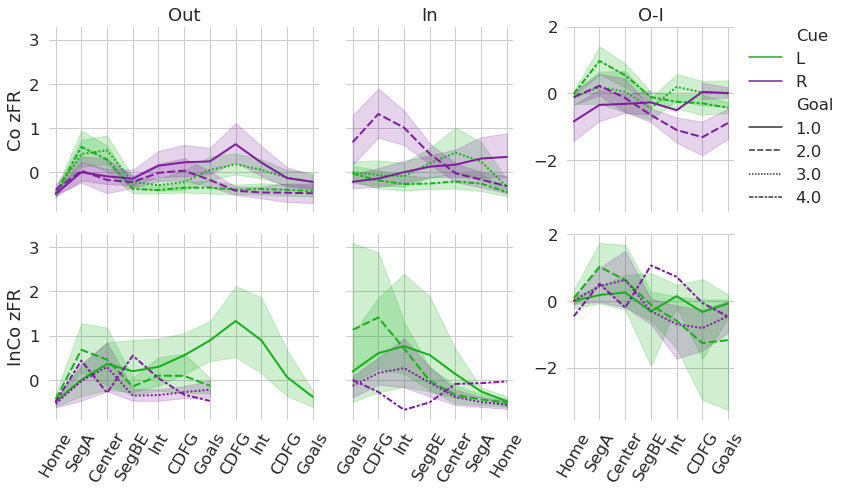

In [433]:
ut = 'Cell'
unitNum = 0
trDat = dat['TrialLongMat']
tR2 = 
if ut == 'Cell':
    tt = dat['ids']['cells'][str(unitNum)][0]
    cl = dat['ids']['cells'][str(unitNum)][1]
    fr = dat['TrialFRLongMat']['cell_'+str(unitNum)]
else:
    tt = dat['ids']['muas'][str(unitNum)][0]
    cl = dat['ids']['muas'][str(unitNum)][1]
    fr = dat['TrialFRLongMat']['mua_'+str(unitNum)] 

#plotTrial_IO(fr,trDat)
#plotTrial_Desc(fr,trDat)
ax=plot_TrLinearized(fr,trDat)
ax[0][2].text([])
dat['TrialModelFits'][['testR2','selMod']]

In [432]:
def plot_TrLinearized(fr,trDat,pos=None):
   
    alpha=0.15
    mlw = 1
    nMaxPos = 11
    nMinPos = 7
    plotAll = False
    
    cellDat = trDat.copy()
    cellDat.loc[:,'zFR'] = fr

    if pos is None:
        f,ax = plt.subplots(2,3, figsize=(15,6))
        h = 0.43
        yorig = 0
        xorig = 0
        yscale = 1
        xscale = 1
    else:
        xorig,yorig,xscale,yscale = pos
        ax={}
        for i in [0,1]:
            for j in [0,1,2]:
                ax[i][j] = plt.axes()
        
    w = 0.25
    ratio = 6.5/10.5
    hsp = 0.05
    vsp = 0.05
    W = [w,w*ratio,w*ratio]
    yPos = np.array([vsp,2*vsp+h])*yscale+yorig
    xPos = np.array([hsp,1.5*hsp+W[0],2.5*hsp+W[1]+W[0]])*xscale+xorig
    xlims = [[-0.25,10.25],[3.75,10.25],[-0.25,6.25]]
    for i in [0,1]:
        for j in np.arange(3):
            ax[i][j].set_position([xPos[j],yPos[i],W[j],h])
            ax[i][j].set_xlim(xlims[j])

    xPosLabels = {}
    xPosLabels[0] = ['Home','SegA','Center','SegBE','Int','CDFG','Goals','CDFG','Int','CDFG','Goals']
    xPosLabels[2] = ['Home','SegA','Center','SegBE','Int','CDFG','Goals']
    xPosLabels[1] = xPosLabels[2][::-1]

    sns.set()
    sns.set(style="whitegrid",context='notebook',font_scale=1.5,rc={
        'axes.spines.bottom': False,
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'axes.edgecolor':'0.5'})

    pal = sns.xkcd_palette(['green','purple'])
    
    with sns.color_palette(pal):
        coSets = ['InCo','Co']
        for i in [0,1]:
            if i==0:
                leg=False
            else:
                leg='brief'

            if plotAll:
                subset = (cellDat['IO']=='Out') & (cellDat['Co']==coSets[i]) & (cellDat['Valid'])
                ax[i][0] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',ci=None,data=cellDat[subset],
                         ax=ax[i][0],legend=False,lw=3,hue_order=['L','R'],style_order=['1','2','3','4'])
                ax[i][0] = sns.lineplot(x='Pos',y='zFR',hue='Desc',estimator=None,units='trID',data=cellDat[subset],
                        ax=ax[i][0],legend=False,lw=mlw,alpha=alpha,hue_order=['L','R'])

                subset = (cellDat['IO']=='In') & (cellDat['Co']==coSets[i]) & (cellDat['Pos']>=4) & (cellDat['Valid'])
                ax[i][1] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',ci=None,data=cellDat[subset],
                         ax=ax[i][1],legend=False,lw=3,hue_order=['L','R'],style_order=['1','2','3','4'])
                ax[i][1] = sns.lineplot(x='Pos',y='zFR',hue='Cue',estimator=None,units='trID',data=cellDat[subset],
                        ax=ax[i][1],legend=False,lw=mlw,alpha=alpha,hue_order=['L','R'])

                subset = (cellDat['IO']=='O_I') & (cellDat['Co']==coSets[i])& (cellDat['Valid'])
                ax[i][2] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',ci=None,data=cellDat[subset],
                            ax=ax[i][2],legend=leg,lw=3,hue_order=['L','R'],style_order=['1','2','3','4'])
                ax[i][2] = sns.lineplot(x='Pos',y='zFR',hue='Cue',estimator=None,units='trID',data=cellDat[subset],
                             ax=ax[i][2],legend=False,lw=mlw,alpha=alpha,hue_order=['L','R'])

            else:
                subset = (cellDat['IO']=='Out') & (cellDat['Co']==coSets[i]) & (cellDat['Valid'])
                ax[i][0] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                                      ax=ax[i][0],lw=2,legend=False,hue_order=['L','R'])#,style_order=['1','2','3','4'])
                subset = (cellDat['IO']=='In') & (cellDat['Co']==coSets[i]) & (cellDat['Pos']>=4) & (cellDat['Valid'])
                ax[i][1] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                                     ax=ax[i][1],lw=2,legend=False,hue_order=['L','R'])#,style_order=['1','2','3','4'])
                subset = (cellDat['IO']=='O_I') & (cellDat['Co']==coSets[i])& (cellDat['Valid'])
                ax[i][2] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                                     ax=ax[i][2],legend=leg,lw=2,hue_order=['L','R'])#,style_order=['1','2','3','4'])

            ax[i][1].set_xticks(np.arange(4,nMaxPos))
            ax[i][0].set_xticks(np.arange(nMaxPos))
            ax[i][2].set_xticks(np.arange(nMinPos))

            for j in np.arange(3):
                ax[i][j].set_xlabel('')
                ax[i][j].set_ylabel('')
                ax[i][j].tick_params(axis='x', rotation=60)

            ax[i][0].set_ylabel('{} zFR'.format(coSets[i]))
            ax[i][1].set_yticklabels('')

            if i==0:
                for j in np.arange(3):
                    ax[i][j].set_xticklabels(xPosLabels[j])
            else:
                ax[i][0].set_title('Out')
                ax[i][1].set_title('In')
                ax[i][2].set_title('O-I')
                for j in np.arange(3):
                    ax[i][j].set_xticklabels('')
        l =ax[1][2].get_legend()
        plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.,frameon=False)
        l.set_frame_on(False)

        # out/in limits
        lims = np.zeros((4,2))
        cnt =0
        for i in [0,1]:
            for j in [0,1]:
                lims[cnt]=np.array(ax[i][j].get_ylim())
                cnt+=1
        minY = np.floor(np.min(lims[:,0])*20)/20
        maxY = np.ceil(np.max(lims[:,1]*20))/20
        for i in [0,1]:
            for j in [0,1]:
                ax[i][j].set_ylim([minY,maxY])

        # o-i limits
        lims = np.zeros((2,2))
        cnt =0
        for i in [0,1]:
            lims[cnt]=np.array(ax[i][2].get_ylim())
            cnt+=1
        minY = np.floor(np.min(lims[:,0])*20)/20
        maxY = np.ceil(np.max(lims[:,1]*20))/20
        for i in [0,1]:
            ax[i][2].set_ylim([minY,maxY])
        
        return ax

In [102]:
def plotLinearTraj2(frDat,trDat,fitTable,savePath):

    cellColIDs =  [i for i,item in enumerate(frDat.columns.values) if 'cell' in item]
    nCells = len(cellColIDs)
    muaColIDs =  [i for i,item in enumerate(frDat.columns.values) if 'mua' in item]
    nMua = len(muaColIDs)
    nTotalUnits = nCells+nMua
    nUnits = {'cell':nCells,'mua':nMua}
    print(nUnits)
    cellCols = frDat.columns[cellColIDs]
    muaCols = frDat.columns[muaColIDs]
    unitCols = {'cell':cellCols,'mua':muaCols}

    nMaxPos = 11
    nMinPos = 7
    plotAll = False
    
    sns.set()
    sns.set(style="whitegrid",context='notebook',font_scale=1.5,rc={
        'axes.spines.bottom': False,
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'axes.edgecolor':'0.5'})

    pal = sns.xkcd_palette(['green','purple'])

    cellDat = trDat.copy()
    c_cnt = -1
    for ut in ['cell','mua']:
        for cell in np.arange(nUnits[ut]):
            c_cnt+=1
            if fitTable['selMod'].iloc[c_cnt]!='UnCla':
                sm = fitTable['selMod'].iloc[c_cnt]
                tR2 = fitTable['testR2'].iloc[c_cnt]
                se = fitTable['se'].iloc[c_cnt]
                print(ut,cell,c_cnt,sm,tR2,se)
                
                print('\nPlotting {} {} {}'.format(ut,cell,sm))
    
                cellDat.loc[:,'zFR'] = frDat[unitCols[ut][cell]]

                f,ax = plt.subplots(2,3, figsize=(15,6))
                w = 0.25
                h = 0.43
                ratio = 6.5/10.5
                hsp = 0.05
                vsp = 0.05
                W = [w,w*ratio,w*ratio]
                yPos = [vsp,2*vsp+h]
                xPos = [hsp,1.5*hsp+W[0],2.5*hsp+W[1]+W[0]]
                xlims = [[-0.25,10.25],[3.75,10.25],[-0.25,6.25]]
                for i in [0,1]:
                    for j in np.arange(3):
                        ax[i][j].set_position([xPos[j],yPos[i],W[j],h])
                        ax[i][j].set_xlim(xlims[j])

                xPosLabels = {}
                xPosLabels[0] = ['Home','SegA','Center','SegBE','Int','CDFG','Goals','CDFG','Int','CDFG','Goals']
                xPosLabels[2] = ['Home','SegA','Center','SegBE','Int','CDFG','Goals']
                xPosLabels[1] = xPosLabels[2][::-1]

                alpha=0.15
                mlw = 1
                with sns.color_palette(pal):
                    coSets = ['InCo','Co']
                    for i in [0,1]:
                        if i==0:
                            leg=False
                        else:
                            leg='brief'

                        if plotAll:
                            subset = (cellDat['IO']=='Out') & (cellDat['Co']==coSets[i]) & (cellDat['Valid'])
                            ax[i][0] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',ci=None,data=cellDat[subset],
                                     ax=ax[i][0],legend=False,lw=3,hue_order=['L','R'],style_order=['1','2','3','4'])
                            ax[i][0] = sns.lineplot(x='Pos',y='zFR',hue='Desc',estimator=None,units='trID',data=cellDat[subset],
                                    ax=ax[i][0],legend=False,lw=mlw,alpha=alpha,hue_order=['L','R'])

                            subset = (cellDat['IO']=='In') & (cellDat['Co']==coSets[i]) & (cellDat['Pos']>=4) & (cellDat['Valid'])
                            ax[i][1] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',ci=None,data=cellDat[subset],
                                     ax=ax[i][1],legend=False,lw=3,hue_order=['L','R'],style_order=['1','2','3','4'])
                            ax[i][1] = sns.lineplot(x='Pos',y='zFR',hue='Cue',estimator=None,units='trID',data=cellDat[subset],
                                    ax=ax[i][1],legend=False,lw=mlw,alpha=alpha,hue_order=['L','R'])

                            subset = (cellDat['IO']=='O_I') & (cellDat['Co']==coSets[i])& (cellDat['Valid'])
                            ax[i][2] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',ci=None,data=cellDat[subset],
                                        ax=ax[i][2],legend=leg,lw=3,hue_order=['L','R'],style_order=['1','2','3','4'])
                            ax[i][2] = sns.lineplot(x='Pos',y='zFR',hue='Cue',estimator=None,units='trID',data=cellDat[subset],
                                         ax=ax[i][2],legend=False,lw=mlw,alpha=alpha,hue_order=['L','R'])

                        else:
                            subset = (cellDat['IO']=='Out') & (cellDat['Co']==coSets[i]) & (cellDat['Valid'])
                            ax[i][0] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                                                  ax=ax[i][0],lw=2,legend=False,hue_order=['L','R'],style_order=['1','2','3','4'])
                            subset = (cellDat['IO']=='In') & (cellDat['Co']==coSets[i]) & (cellDat['Pos']>=4) & (cellDat['Valid'])
                            ax[i][1] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                                                 ax=ax[i][1],lw=2,legend=False,hue_order=['L','R'],style_order=['1','2','3','4'])
                            subset = (cellDat['IO']=='O_I') & (cellDat['Co']==coSets[i])& (cellDat['Valid'])
                            ax[i][2] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                                                 ax=ax[i][2],legend=leg,lw=2,hue_order=['L','R'],style_order=['1','2','3','4'])

                        ax[i][1].set_xticks(np.arange(4,nMaxPos))
                        ax[i][0].set_xticks(np.arange(nMaxPos))
                        ax[i][2].set_xticks(np.arange(nMinPos))

                        for j in np.arange(3):
                            ax[i][j].set_xlabel('')
                            ax[i][j].set_ylabel('')
                            ax[i][j].tick_params(axis='x', rotation=60)

                        ax[i][0].set_ylabel('{} zFR'.format(coSets[i]))
                        ax[i][1].set_yticklabels('')

                        if i==0:
                            for j in np.arange(3):
                                ax[i][j].set_xticklabels(xPosLabels[j])
                        else:
                            ax[i][0].set_title('Out')
                            ax[i][1].set_title('In')
                            ax[i][2].set_title('O-I')
                            for j in np.arange(3):
                                ax[i][j].set_xticklabels('')
                    l =ax[1][2].get_legend()
                    plt.legend(bbox_to_anchor=(1.05, 0), loc=6, borderaxespad=0.,frameon=False)
                    l.set_frame_on(False)

                    # out/in limits
                    lims = np.zeros((4,2))
                    cnt =0
                    for i in [0,1]:
                        for j in [0,1]:
                            lims[cnt]=np.array(ax[i][j].get_ylim())
                            cnt+=1
                    minY = np.floor(np.min(lims[:,0])*20)/20
                    maxY = np.ceil(np.max(lims[:,1]*20))/20
                    for i in [0,1]:
                        for j in [0,1]:
                            ax[i][j].set_ylim([minY,maxY])

                    # o-i limits
                    lims = np.zeros((2,2))
                    cnt =0
                    for i in [0,1]:
                        lims[cnt]=np.array(ax[i][2].get_ylim())
                        cnt+=1
                    minY = np.floor(np.min(lims[:,0])*20)/20
                    maxY = np.ceil(np.max(lims[:,1]*20))/20
                    for i in [0,1]:
                        ax[i][2].set_ylim([minY,maxY])
                    
                    txtstr = 'SelMod \n{0} \n\n tR2={1:.2f}'.format(sm,tR2)
                    f.text(0.7,0.15,txtstr,fontsize=10)
                    
                    sp = savePath/sm
                    sp.mkdir(parents=True,exist_ok=True)
                    
                    fn = 'LinearizedTr_{}_{}_ID-{}.jpeg'.format(se,ut,cell)
                    f.savefig(str(sp/fn),dpi=150, bbox_inches='tight',pad_inches=0.2)
                    plt.close(f)


50.336950627288736

In [ ]:
def plotTrialConds2(frDat,trDat,fitTable,savePath):

    cellColIDs =  [i for i,item in enumerate(frDat.columns.values) if 'cell' in item]
    nCells = len(cellColIDs)
    muaColIDs =  [i for i,item in enumerate(frDat.columns.values) if 'mua' in item]
    nMua = len(muaColIDs)
    nTotalUnits = nCells+nMua
    nUnits = {'cell':nCells,'mua':nMua}

    cellCols = frDat.columns[cellColIDs]
    muaCols = frDat.columns[muaColIDs]
    unitCols = {'cell':cellCols,'mua':muaCols}

    sns.set()
    sns.set(style="whitegrid",context='notebook',font_scale=1.5,rc={
        'axes.spines.bottom': False,
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'axes.edgecolor':'0.5'})

    cellDat = trDat.copy()
    c_cnt = -1
    for ut in ['cell','mua']:
        for cell in np.arange(nUnits[ut]):
            c_cnt+=1
            if fitTable['selMod'].iloc[c_cnt]!='UnCla':
                sm = fitTable['selMod'].iloc[c_cnt]
                tR2 = fitTable['testR2'].iloc[c_cnt]
                se = fitTable['se'].iloc[c_cnt]
                print(ut,cell,c_cnt,sm,tR2,se)
                
                print('\nPlotting {} {} {}'.format(ut,cell,sm))
                
                cellDat.loc[:,'zFR'] = frDat[unitCols[ut][cell]]

                f,ax = plt.subplots(1,2, figsize=(10,4))

                # Correct Trials Out/In O_I
                subset = cellDat['Co']=='Co'
                dat =[]
                dat = cellDat[subset].groupby(['trID','IO','Cue','Desc']).mean()
                dat = dat.reset_index()

                pal = sns.xkcd_palette(['spring green','light purple'])
                with sns.color_palette(pal):
                    ax[0]=sns.violinplot(y='zFR',x='IO',hue='Desc',data=dat,split=True, ax=ax[0],
                                      scale='count',inner='quartile',hue_order=['L','R'],saturation=0.5,order=['Out','In','O_I'])
                pal = sns.xkcd_palette(['emerald green','medium purple'])
                with sns.color_palette(pal):
                    ax[0]=sns.swarmplot(y='zFR',x='IO',hue='Desc',data=dat,dodge=True,hue_order=['L','R'],alpha=0.7,ax=ax[0],
                                     edgecolor='gray',order=['Out','In','O_I'])
                l=ax[0].get_legend()
                l.set_visible(False)
                ax[0].set_xlabel('Direction')

                #
                subset= cellDat['IO']=='Out'
                dat = []
                dat = cellDat[subset].groupby(['trID','Cue','Co','Desc']).mean()
                dat = dat.reset_index()

                pal = sns.xkcd_palette(['spring green','light purple'])
                with sns.color_palette(pal):
                    ax[1]=sns.violinplot(y='zFR',x='Desc',hue='Cue',data=dat,split=True,scale='width',ax=ax[1],
                                      inner='quartile',order=['L','R'],hue_order=['L','R'],saturation=0.5)
                pal = sns.xkcd_palette(['emerald green','medium purple'])
                with sns.color_palette(pal):
                    ax[1]=sns.swarmplot(y='zFR',x='Desc',hue='Cue',data=dat,dodge=True,order=['L','R'],ax=ax[1],
                                        hue_order=['L','R'],alpha=0.7,edgecolor='gray')

                #
                ax[1].set_xlabel('Decision')
                ax[1].set_ylabel('')
                l=ax[1].get_legend()
                handles, labels = ax[1].get_legend_handles_labels()
                l.set_visible(False)
                plt.legend(handles[2:],labels[2:],bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.,frameon=False,title='Cue')

                
                txtstr = 'SelMod \n{0} \n\n tR2={1:.2f}'.format(sm,tR2)
                f.text(0.9,0.65,txtstr,fontsize=10)
                
                sp = savePath/sm
                sp.mkdir(parents=True,exist_ok=True)

                fn = 'TrialConds_{}_{}_ID-{}.jpeg'.format(se,ut,cell)
                f.savefig(str(sp/fn),dpi=150, bbox_inches='tight',pad_inches=0.2)
                plt.close(f)

In [333]:
dat['ids']

{'cells': {'0': ['3', '1'],
  '1': ['3', '8'],
  '2': ['7', '0'],
  '3': ['8', '13'],
  '4': ['8', '14']},
 'muas': {'0': ['1', '0'],
  '1': ['1', '3'],
  '2': ['2', '8'],
  '3': ['2', '9'],
  '4': ['3', '2'],
  '5': ['4', '11'],
  '6': ['4', '12'],
  '7': ['5', '12'],
  '8': ['6', '0'],
  '9': ['10', '2'],
  '10': ['10', '6'],
  '11': ['10', '7'],
  '12': ['10', '8'],
  '13': ['10', '10'],
  '14': ['14', '0'],
  '15': ['14', '3'],
  '16': ['14', '12']}}